# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [577]:
names = {'student_1': "Manana Lortkipanidze",
         'student_2': "Devavrat Tomar"}

sciper = {'student_1': 263851, 
          'student_2': 295271}

seed = sciper['student_1'] + sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os, sys
import copy
from random import randint

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    f = open(datapath+file)
    conversations = []
    current_conversation = []
    for l, line in enumerate(f):
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue
        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

In [173]:
# helpers from mini-project 1
import matplotlib.pyplot as plt

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    #ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history['loss'], label = "training")
    ax1.plot(history['val_loss'], label = "validation")
    ax2.plot(history['acc'], label = "training")
    ax2.plot(history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    ax1.grid()
    ax2.grid()
    fig.set_figheight(5)
    fig.set_figwidth(15)
    return fig

## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [125]:
conversations = getRawDataFromFile()

In [32]:
random_int = np.random.randint(0, len(conversations), 2)
# Displaying conversation 
print("Two randomly selected conversations: \n{}\n{}".format(conversations[random_int[0]], conversations[random_int[1]]))

Two randomly selected conversations: 
['hello , and how are you this day ?', 'fabulous ! i am called gerald . i just finished my shift at mcdonalds .', 'really . i model . i love to model animal clothing', 'i listen to lots of rock music in my spare time . what do you do ?', 'i shop and look good', 'the boston celtics are my favorite basketball team because they wear green , my favorite color !', 'well you would like my eyes then . also my shades', 'do you have a favorite sport or color ?', 'my favorite color is black . what is yours', 'green is my favorite color . rock is my favorite music . basketball is favorite sport .', 'ok . cool olive colored tone is my favorite shade but i love others as well', 'wow ! you sound like a fun and interesting person !', 'yes i think so . i guess its time for me to go so goodbye .', 'have a lovely evening ! take care !', 'you have one as well . it was nice talking to you .', 'lovely talking to you too !']
['hi there ! how are you ?', 'i just acted li

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** Zip's law suggests that rank of a word is inversely propotional to its frequency. There, such relationship should result in a linear relationship on log-log scale with negative slope $frequency$ ~ $\frac{1}{rank^n}$. As we can see from out plot we have approximately line (with negative slope). Thus, we can say that Zip's law approximately holds. However, we can observe nonlinearity(oscillations) at the end which usually can disappear with cumulative frequency distribution.

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** 7080 words appeared only once.



<b>Code Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt] </b>

In [33]:
def get_word_dictionary(conversations):
    """
    Computes the set of unique words (dictionary) in all sentences along with their number of occurences.
    
    :param conversations: List of all conversations
    """
    word_dict = {}
        
    print("Creating dictionary")
    # First we need to extract all sentences from conversations
    for conversation in conversations:
        for sentence in conversation:
            words = sentence.split(' ')
            for word in words:
                if word in word_dict:
                    word_dict[word] += 1
                else:
                    word_dict[word] = 1
                    
                    
    print("Number of unique words: %d"%len(word_dict))
    
    return word_dict

In [34]:
word_dictionary = get_word_dictionary(conversations)
sorted_word_dictionary = sorted(word_dictionary.items(), key=lambda kv: kv[1], reverse=True)

Creating dictionary
Number of unique words: 18673


<b>Figure: In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]</b>

In [35]:
def plot_bar_tuples(list_tuples, title, x_label, y_label, fig_size=(15,8)):
    """
    Create bar chart with vertical labels on x-axis
    
    :param list_tuples: labels with their corresponding count
    :param title:       title of the plot
    :param x_label:     label for the x-axis
    :param y_label:     label for the y-axis
    :param fig_size:    size of the figure, optional
    """
    plt.figure(figsize=fig_size)
    x , y = zip(*list_tuples)
    x_pos = np.arange(len(list_tuples))
    plt.bar(x_pos, y, align='center', alpha=0.5)
    plt.xticks(x_pos, x, rotation='vertical')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
   
    plt.show()   

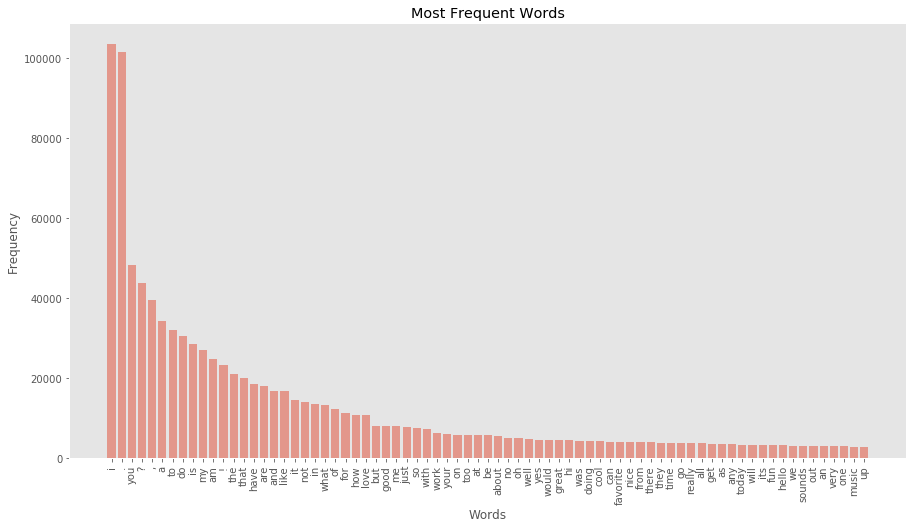

In [36]:
plot_bar_tuples(sorted_word_dictionary[0:75], "Most Frequent Words", "Words", "Frequency")

<b>Figure In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] </b>

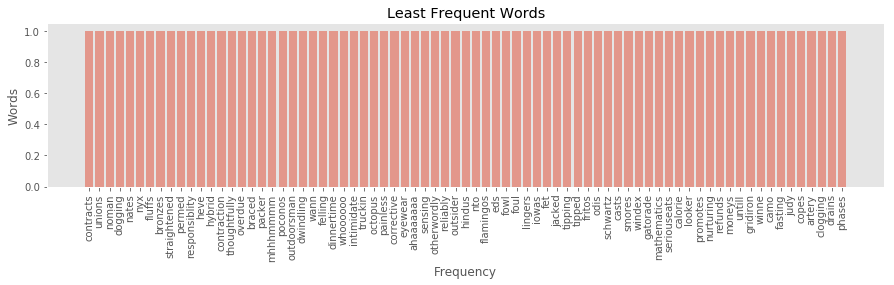

In [37]:
plot_bar_tuples(sorted_word_dictionary[-75:], "Least Frequent Words", "Frequency", "Words", (15,3))

<b>Figure In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]</b>

In [134]:
def plot_log_log(data, title, x_label, y_label):
    """
    Plot data on log-log axis
    
    :param data:      data to be plotted
    :param title:     title of the figure
    :param x_label:   label of the x-axis
    :param y_label:   label of the y-axis
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle(title)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_ylim(1, max(data))
    ax.set_xlim(1, max(data))
    plt.gca().set_aspect('equal', adjustable='box')
    ax.plot(data)

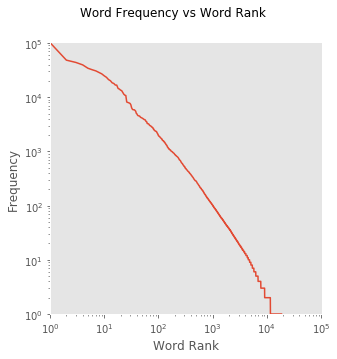

In [135]:
plot_log_log([word_count[1] for word_count in sorted_word_dictionary],
             "Word Frequency vs Word Rank", "Word Rank", "Frequency")

<b>Question How many words appear only once in the entire dataset? [1 pt]</b>

In [40]:
# number of words with count one
words_count_one = [word_count[0] for word_count in word_dictionary.items() if word_count[1] == 1]

In [41]:
count_one_nb   = len(words_count_one)
count_one_perc = len(words_count_one) * 100.0 / len(word_dictionary)
print("Number of words that occur only once: %d (%0.2f%% of the whole vocabulary)"%(count_one_nb, count_one_perc))

Number of words that occur only once: 7080 (37.92% of the whole vocabulary)


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: Removed 11807 words from total of 18673 words.

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: 114615 sentences in filtered and 131424 sentences in an old dataset.

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**:  ToDo run with and without and explain results with some theoretical knowledge. Draft: in case of next word prediction, you can not predict a word that is not in a dictionary

<b>Code To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]</b>

In [42]:
threshold=5
filtered_dict = {k:v for k,v in word_dictionary.items() if v >= threshold}
rare_words = {k for k,v in word_dictionary.items() if v < threshold}
print("Removed %d words from total of %d words"%(len(rare_words), len(word_dictionary)))

Removed 11807 words from total of 18673 words


In [142]:
def contains_rare_word(sentence, rare_words):
    """
    Checks if sentence contains any of the rare words
    :param sentence:   Sentence to be checked
    :param rare_words: List of the rare words
    
    :return:           Whether sentence contains any of the rare words
    """
    for word in sentence:
        if word in rare_words:
            return True
    return False

def filter_dataset(conversations, rare_words):
    """ 
    Returns filtered dataset containing sentences in which rare words do not accur
    
    :conversations: conversations dataset
    :rare_words:    list of rare words
    
    :return:        filtered dataset
    """
    
    filtered_dataset = []
    old_sentence_nb  = 0
    filt_sentence_nb = 0
    
    for conversation in conversations:
        filtered_conversation = []
        for sentence in conversation:
            split_sentence = sentence.split(" ")
            
            if (not contains_rare_word(split_sentence, rare_words)):
                filtered_conversation.append(split_sentence)
        
        if filtered_conversation: # If it is not empty
            filtered_dataset.append(filtered_conversation)
            
        old_sentence_nb  += len(conversation)
        filt_sentence_nb += len(filtered_conversation)
        
    print("Filtered %d out of %d sentences"%(old_sentence_nb-filt_sentence_nb, old_sentence_nb))
    print("%d sentences in filtered and %d sentences in an old dataset."%(filt_sentence_nb, old_sentence_nb))

    return filtered_dataset

In [143]:
filtered_conversations = filter_dataset(conversations, rare_words)

Filtered 16809 out of 131424 sentences
114615 sentences in filtered and 131424 sentences in an old dataset.


### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

<b>Code Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. HINT: use the Python List index() method. [2 pts]</b>

In [144]:
def create_dict_mapping(dictionary):
    """
    Creates an array from dictionary where index of an token is its mapping
    
    :param dictionary: dictionary to be mapped
    
    :return: mapping of the dictionary
    """
    dict_mapping = ['PADD']
    dict_mapping += list(dictionary)
    dict_mapping.append('START')
    dict_mapping.append('END')
    
    return dict_mapping
    
dict_mapping = create_dict_mapping(filtered_dict)

In [145]:
def map_conversations(conversations, dict_mapping):
    """
    Maps words/tokens of conversation to its corresponding integers
    
    :param conversations:   conversation to be mapped
    :param dict_mapping:    mapping of tokens defined by their index
    
    :return: mapped conversation
    """
    
    mapped_conversations = []
    
    for conversation in conversations:
        mapped_conversation = []
        for sentence in conversation:
            mapped_sentence = [dict_mapping.index('START')]
            for word in sentence:
                mapped_sentence.append(dict_mapping.index(word))
            mapped_sentence.append(dict_mapping.index('END'))
            mapped_conversation.append(mapped_sentence)
        mapped_conversations.append(mapped_conversation)
    return mapped_conversations

mapped_conversations = map_conversations(filtered_conversations, dict_mapping)

<b>Figure: Use the violinplot to show the density of tokenized sentences length. [1pt]</b>

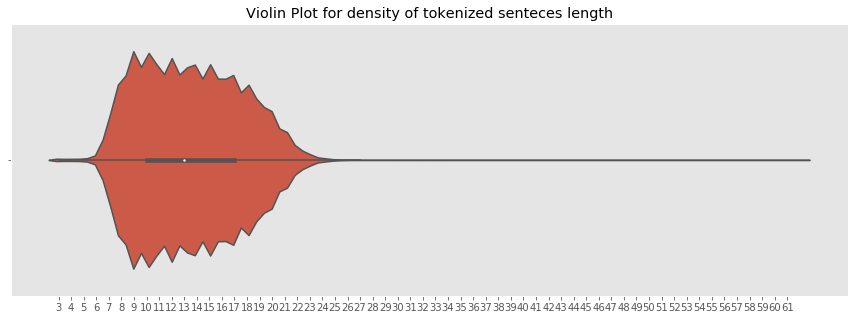

In [147]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 5))
#plt.figure(figsize=(15, 5))
plt.title("Violin Plot for density of tokenized senteces length")
sentence_length = [len(sentence) for conversation in mapped_conversations for sentence in conversation]
sns.violinplot(x=sentence_length)
start, end = (min(sentence_length), max(sentence_length))
ax.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()

<b> Code: From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen). HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts] </b>

In [149]:
def standardize_conversations(conversations, max_tokens):
    """
    Standardizes conversations so that each sentence has max_tokens tokens either padding or truncating
    
    :param conversations: conversations to be standardized
    :param max_tokens:    number of tokens per sentence
    
    :return:              standardized conversations
    """
    stand_convs = []
    
    for conversation in conversations:
        stand_convs.append(pad_sequences(conversation, maxlen=max_tokens, padding='post', truncating='post'))    
    return stand_convs

In [150]:
#ToDo ask the TAs about this 
max_tokens = 25

In [151]:
stand_convs = standardize_conversations(mapped_conversations, max_tokens)

<b> Code Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt] </b>

In [152]:
def recover_sentence(sentence, mapped_dict):
    # remove padding
    unpadded_sentence = [index for index in sentence if index != dict_mapping.index('PADD')]
    # map integers back to words
    word_sentence = [mapped_dict[index] for index in unpadded_sentence]
    # remove start and end
    return word_sentence[1:-1]

In [153]:
# original sentences 
sentences = [sentence for conversation in filtered_conversations for sentence in conversation]
# standardizes sentences with tokenization, padding and length standardization
std_sentences = np.array([sentence for conversation in stand_convs for sentence in conversation])

In [154]:
# reconstruct two random sentences
for i in range(2):
    index = randint(0, len(sentences))
    print("Original Sentence: %s"%sentences[index])
    print("Standardized Sentence: %s"%std_sentences[index])
    print("Reconstructed Sentence: %s \n"%recover_sentence(std_sentences[index], dict_mapping))

Original Sentence: ['hello', ',', 'i', 'do', 'not', 'play', 'any', 'sports', '.', 'do', 'you', 'have', 'a', 'favorite', 'food', '?']
Standardized Sentence: [6867  272    2    8   13   43   87   71  635   20   13    5   55   56
   30  810    7 6868    0    0    0    0    0    0    0]
Reconstructed Sentence: ['hello', ',', 'i', 'do', 'not', 'play', 'any', 'sports', '.', 'do', 'you', 'have', 'a', 'favorite', 'food', '?'] 

Original Sentence: ['so', 'what', 'brings', 'you', 'round', 'these', 'parts', '?']
Standardized Sentence: [6867  315   65 2630    5 2806 1186 1581    7 6868    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
Reconstructed Sentence: ['so', 'what', 'brings', 'you', 'round', 'these', 'parts', '?'] 



### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [157]:
import pickle

def save_data():    
    #save
    with open("data.pkl", "wb") as file:
        pickle.dump([filtered_conversations, filtered_dict, dict_mapping, std_sentences], file)

def load_data():
    #load
    with open("data.pkl", "rb") as file:
         return pickle.load(file)
        
#save_data()

[filtered_conversations, filtered_dict, dict_mapping, std_sentences] = load_data()

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** We include a mask layer after the embedding layer (using argument mask_zero=True in Embedding keras layer) treating 'PADD' (integer 0) input as end of the sequence. This allows RNN to process sequences of arbitary length from 1 to max_token and discard padded inputs.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer** This network is modelled to predict next word given the previous  $n$ words in the sentence. Thus, we can treat the softmax output of the neural network as conditional probability distribution of $(n+1)^{th}$ word given the past $n$ words (i.e. transition probability of next word, given the past words).

For each batch, the inputs are the integer word sequences and targets are the same word sequences but with one step delayed. Thus, the neural network learns to predict next word in the sentence given previous words.

Input tensor dimension: [batch_size, max_time_step -1, 1]  
Output tensor dimension: [batch_size, max_time_step -1, 1]  
Where max_time_step is the length of a given sentence.

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: 

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: 

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: 

<b>code You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]</b>

In [159]:
nb_tokens = len(dict_mapping)
print("Size of dictionary: %d"%nb_tokens)

Size of dictionary: 6869


In [160]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [6]:
# input layers
I = {}
# embedding layers
E = {}
# hidden layers
H = {}
# readout
R = {}
# output 
Y = {}
models = {}
logs = {}

In [7]:
X = std_sentences
# convert output to shape [batch_size, max_step, feature_size]
T = std_sentences.reshape((std_sentences.shape[0], std_sentences.shape[1], 1))

In [578]:
def append_run_language_model(nb_tokens,
                              input_len,
                              embedding_size,
                              hidden_size,
                              n_hidden_layers,
                              I, E, H, R, Y,
                              models,
                              logs,
                              X, T,
                              dropout=0.0,
                              recurrent_dropout=0.0,
                              early_stopping=False,
                              embedding_weights=None,
                              model_type='RNN',
                              model_name=''):
    """
    Appends models to the dictionary
    
    :param nb_tokens:             vocabulary size
    :param input_len:             lenght of input sentences
    :param embedding_size:        dimension of word embeddings
    :param hidden_size:           output size of RNN/ neurons in recurrent hidden layers
    :param n_hidden_layers:       number of recurrent hidden layers
    :param I, E, H, R, Y:         dictionaries poiting to the model layers
    :param models:                dictionary to append the trained model
    :param logs:                  dictionary to store logs (train/val history)
    :param x:                     input
    :param T:                     target
    :param dropout:               dropout probability in non recurrent layers
    :param recurrent_dropout:     dropout probability in the recurrent layers
    :param early_stopping:        Whether to use the early stopping technique
    :param embedding_weights:     list of embeddings, otherwise embedding is learnt in this function
    :param model_type:            type of a model, 'RNN' by default
    :param model_name:            name of the model, final name will be model_type model_name
    """
    
    model_name = model_type + model_name
    
    # create an input layer
    I[model_name] = Input(shape=(input_len-1,), name="input")
    
    # if word embeddings are not given, create them otherwise create Embedding of the given weights
    if embedding_weights is None:
        E[model_name] = Embedding(nb_tokens,         # size of the vocabulary
                                  embedding_size,    # dimension of word embedding
                                  mask_zero=True,    # specify we have padding represented as 0s
                                  name="embedding",
                                  input_length=input_len-1)(I[model_name]) # we pass the output of prev layer to the input
    else:
        E[model_name] = Embedding(nb_tokens,
                                  embedding_size,
                                  mask_zero=True,
                                  weights=embedding_weights,
                                  name="embedding",
                                  input_length=input_len-1,
                                  trainable=False)(I[model_name])
    if model_type == 'RNN':
        rnn_cell = SimpleRNN
    elif model_type == 'GRU':
        rnn_cell = GRU
    elif model_type == 'LSTM':
        rnn_cell = LSTM
    else:
        raise Exception('model type is not defined')
    
    # output of the last layer
    out = E[model_name]
    
    #create hidden recurrent layers
    for _ in range(n_hidden_layers):
        out = rnn_cell(hidden_size,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       return_sequences=True)(out)  # whether to return the last state in addition to the output
    
    H[model_name] = out
    R[model_name] = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(H[model_name])
    Y[model_name] = TimeDistributed(Dense(nb_tokens, activation='softmax'), name='output')(R[model_name])

    models[model_name] = Model(inputs = [I[model_name]], outputs = [Y[model_name]])
    
    models[model_name].compile(
        loss='categorical_crossentropy', # we needed to update keras since this function produces bug on latest version
        optimizer=Adam(),
        metrics=['acc'])
    models[model_name].summary()
    
    print(X[:,:-1].shape, T[:,1:].shape)
    
    cb = [EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)] if early_stopping else []
    
    # ToDo why are we doing :dataset_cut??? ToDo remove dataset_cut
    logs[model_name] = models[model_name].fit({'input': X[:dataset_cut,:-1]}, {'output': to_categorical(X[:dataset_cut,1:])}, 
                                              epochs=epochs,
                                              validation_split=validation_split,
                                              batch_size=batch_size,
                                              callbacks=cb).history

    #save logs
    with open(model_type+"model_"+str(embedding_size)+'_'+str(hidden_size)+'_'+str(n_hidden_layers)+"_log.pkl", "wb") as file:
        pickle.dump(logs[model_type], file)
        
    #save model
    models[model_name].save(model_type+"model_"+str(embedding_size)+'_'+str(hidden_size)+'_'+str(n_hidden_layers))

<b>code Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt] </b>

In [579]:
# Simple rnn model
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          hidden_size,
                          1,
                          I, E, H, R, Y,
                          models,
                          logs,
                          X, T,
                          model_type='RNN')

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           879232    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 24, 64)            12352     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 6869)          886101    
Total params: 1,786,005
Trainable params: 1,786,005
Non-trainable params: 0
_________________________________________________________________
(114615, 24) (114615, 24, 1)
Train on 91691 samples, validate on 22923 samples
Epoch 1/32
91691/91691 [===========

KeyboardInterrupt: 

In [163]:
def load_model_logs(model_path):
    #load RNN Model
    with open(model_path, "rb") as file:
        RNNmodel_log = pickle.load(file)
    return RNNmodel_log

In [12]:
#GRU model
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          hidden_size,
                          1,
                          I, E, H, R, Y,
                          models,
                          logs,
                          X, T,
                          model_type='GRU')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           879232    
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 6869)          886101    
Total params: 1,810,709
Trainable params: 1,810,709
Non-trainable params: 0
_________________________________________________________________
(114615, 24) (114615, 24, 1)
Train on 91691 samples, validate on 22923 samples
Epoch 1/32
91691/91691 [============

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
#LSTM model
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          hidden_size,
                          1,
                          I, E, H, R, Y,
                          models,
                          logs,
                          X, T,
                          model_type='LSTM')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           879232    
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 64)            49408     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 6869)          886101    
Total params: 1,823,061
Trainable params: 1,823,061
Non-trainable params: 0
_________________________________________________________________
(114615, 24) (114615, 24, 1)
Train on 91691 samples, validate on 22923 samples
Epoch 1/32
91691/91691 [============

<b>Figure Show the learning curves (training and validation loss) for the different recurrent units. [1 pt] </b>

<b>Figure Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt] </b>

In [164]:
# read saved logs
RRN_logs  = load_model_logs("RNNmodel_128_64_1_log.pkl")
GRU_logs  = load_model_logs("GRUmodel_128_64_1_log.pkl")
LSTM_logs = load_model_logs("LSTMmodel_128_64_1_log.pkl")

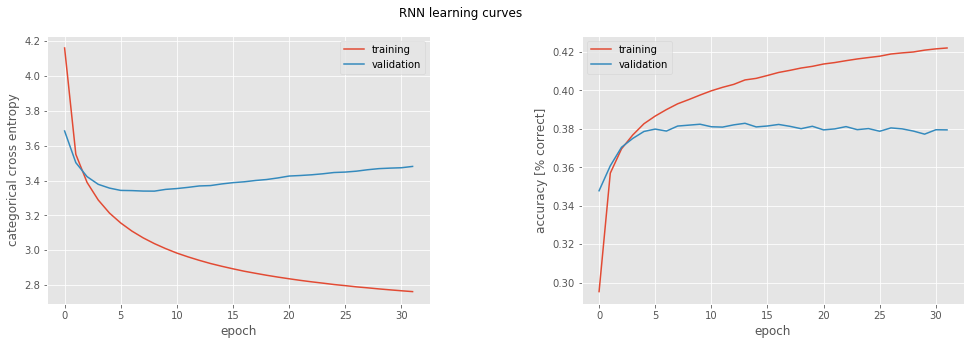

In [175]:
fig_RNN = plot_history(RRN_logs, "RNN learning curves")

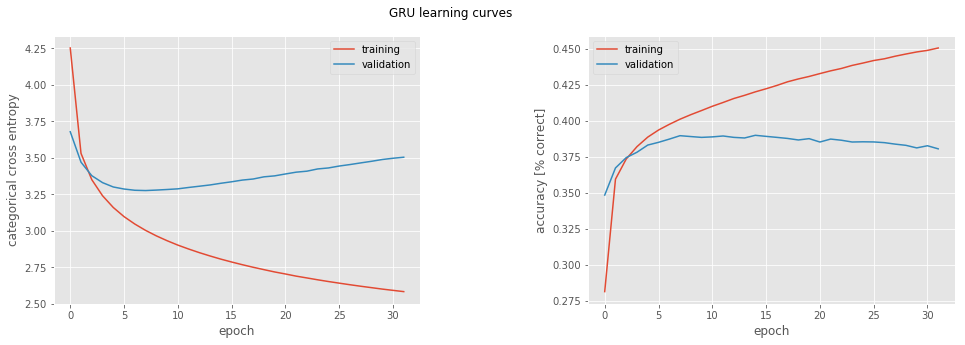

In [176]:
fig_GRU = plot_history(GRU_logs, "GRU learning curves")

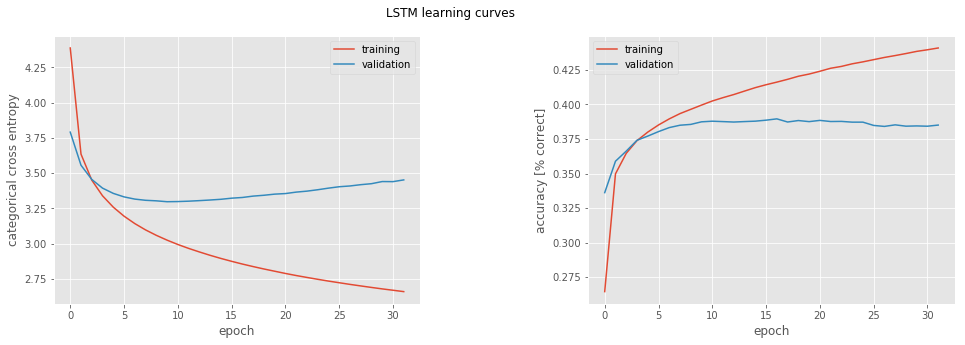

In [177]:
fig_LSTM = plot_history(LSTM_logs, "LSTM learning curves")

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer**

**Question** What is your best model? Why? [1 pt]

**Answer**



In [178]:
I_GRU = {}
E_GRU = {}
H_GRU = {}
R_GRU = {}
Y_GRU = {}
# Get weigths of the embedding layer of pretrained model
embeddings_pre_trained = models['GRU'].layers[1].get_weights()

In [30]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          128,
                          1,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='128')

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           879232    
_________________________________________________________________
gru_4 (GRU)                  (None, 24, 128)           98688     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           16512     
_________________________________________________________________
output (TimeDistributed)     (None, 24, 6869)          886101    
Total params: 1,880,533
Trainable params: 1,001,301
Non-trainable params: 879,232
_________________________________________________________________
(114615, 24) (114615, 24, 1)
Train on 91691 samples, validate on 22923 samples
Epoch 1/32
91691/91691 [======

In [179]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          256,
                          1,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='256')

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           879232    
_________________________________________________________________
gru_5 (GRU)                  (None, 24, 256)           295680    
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           32896     
_________________________________________________________________
output (TimeDistributed)     (None, 24, 6869)          886101    
Total params: 2,093,909
Trainable params: 1,214,677
Non-trainable params: 879,232
_________________________________________________________________
(114615, 24) (114615, 24, 1)
Train on 91691 samples, validate on 22923 samples
Epoch 1/32
91691/91691 [======

In [ ]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          64,
                          2,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='64_2')

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           879232    
_________________________________________________________________
gru_6 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
gru_7 (GRU)                  (None, 24, 64)            24768     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 6869)          886101    
Total params: 1,835,477
Trainable params: 956,245
Non-trainable params: 879,232
_____________________________________________

<b>Figure Show the learning curves (training and validation loss) for the four models. [1 pt] </b>

<b>Figure Show the learning curves (training and validation accuracy) for the four models. [1 pt]</b>

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer**

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer**

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer**

<b> Code To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts] </b>

In [219]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    
    # smoothing, adding small value for zero probabilities
    preds = np.log(preds + 1e-8) / temperature
    
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [479]:
def generate_sentence(model, dict_mapping, temperature=1., sentence=[], max_tokens=24):
    """
    Generates new sentences from model
    
    :param model:         model for predictions
    :pemperature:         temperature to be used for sampling
    :sentence:            initial sentence given, created in method if None.
                          don't add START or END symbol to initial sentence. sentence should be a list of tokens (str or mapped)
    :dict_mapping:        list of vocabulary words where index of word gives its integer representation for embedding layer.
    """
    
    # store actual predicted words
    word_sentence = sentence.copy()
    word_mapping =  []
    
    # store prediction at each sentence position
    all_preds = []
    
    # start predicting from this index
    prediction_start = len(sentence)
    
    
    # check type of sentence is empty list
    if sentence and type(sentence[0] is str):
        sentence = [dict_mapping.index(word) for word in sentence]
    
    sentence = [dict_mapping.index('START')] + sentence
    sentence = pad_sequences([sentence], maxlen=max_tokens, padding='post', truncating='post')
    
    for i in range(prediction_start, max_tokens-1):
        
        # get predictions for the current sentence
        preds = model.predict(sentence)
        
        # save predictions for words for i+1 th position
        all_preds.append(preds[0][i])
        
        # sample the word prediciton for position i+1
        next_word = sample(preds[0][i], temperature)
        
        # if the sentence end was predicted, end the process
        if(next_word == dict_mapping.index('END')):
            break
        
        # insert predicted word (integer mapping) into sentence
        sentence[0, i+1] = next_word
        
        # save an actual predicted word
        word_sentence.append(dict_mapping[next_word])
        
        # save the predicted word (its token)
        word_mapping.append(next_word)
               
    # from all predictions select predictions only for words in the sentence
    sentence_word_preds = np.array(all_preds)[:, word_mapping]
    
    return " ".join(word_sentence), sentence_word_preds

In [468]:
sen, preds = generate_sentence(models['GRU'], dict_mapping=dict_mapping)
sen

'i am pretty busy with school'

<b> Code Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt] </b>

In [473]:
def generate_sentences(model, temperatures, dict_mapping):
    """
    Generate 10 senteces according to the model for each temperature in temperatures
    """

    temp_sentences = dict()
    temp_preds = dict()
    
    for temp in temperatures:
        print("Temperature: %.2f"%temp)
        for i in range(10):
            # generate a sentece according to the model and temperature
            sentence, preds = generate_sentence(model, temperature=temp, dict_mapping=dict_mapping)
            print("%d) %s"%(i+1, sentence))
            
            if temp in temp_sentences:
                temp_sentences[temp].append(sentence)
                temp_preds[temp].append(preds)
            else:
                temp_sentences[temp] = [sentence]
                temp_preds[temp] = [preds]
    
    return temp_sentences, temp_preds

In [474]:
temperatures = np.arange(0, 2.1, 0.25)    
temp_sentences, temp_preds = generate_sentences(models['GRU'], temperatures, dict_mapping=dict_mapping)

Temperature: 0.00
1) i am a teacher . i am a big fan of it .
2) i am a teacher . i am a big fan of it .
3) i am a teacher . i am a big fan of it .
4) i am a teacher . i am a big fan of it .
5) i am a teacher . i am a big fan of it .
6) i am a teacher . i am a big fan of it .
7) i am a teacher . i am a big fan of it .
8) i am a teacher . i am a big fan of it .
9) i am a teacher . i am a big fan of it .
10) i am a teacher . i am a big fan of it .
Temperature: 0.25
1) i am a teacher . what do you do for fun ?
2) i am a teacher , but i do not like to go to the gym
3) i am a teacher , but i am a big fan of it
4) i am a stay at home mom , but i am a big fan of them
5) i am doing well . i just got back from a run .
6) i am a big fan of pink floyd .
7) i am in cali , and i am a little ocd and now husband
8) i am doing well , thank you . what are your hobbies ?
9) i am a college student , i am a big fan of it .
10) i am a big fan of the chain smokers . do you ?
Temperature: 0.50
1) oh , i just 

<b> 7 Figures For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts] </b>

Temperature: 0.00, Sentence: i am a teacher . i am a big fan of it .


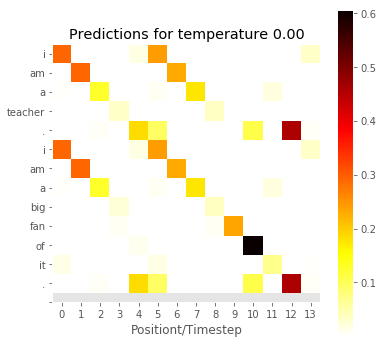

Temperature: 0.25, Sentence: i am a teacher . what do you do for fun ?


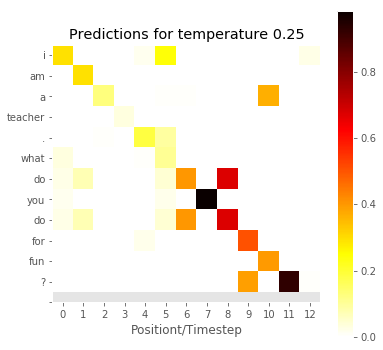

Temperature: 0.50, Sentence: oh , i just got done working out . what do you do for fun ?


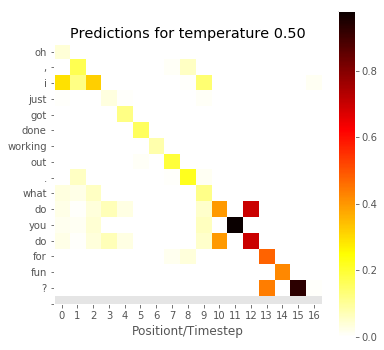

Temperature: 0.75, Sentence: do you work at all ?


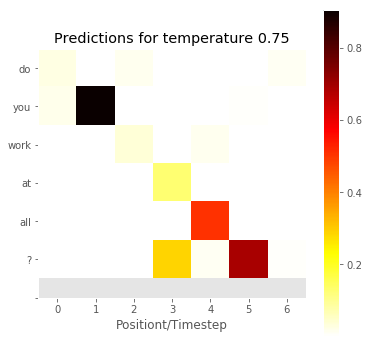

Temperature: 1.00, Sentence: lol ! i work as a graphic designer


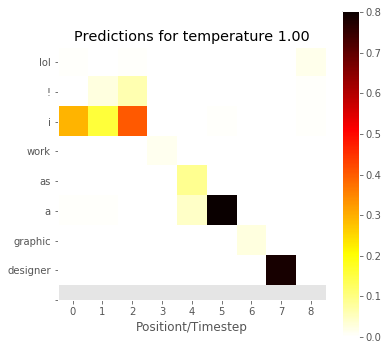

Temperature: 1.25, Sentence: i never do not work but i always heard much things bring grass


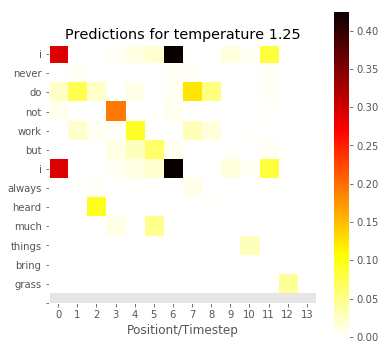

Temperature: 1.50, Sentence: both my friends loved it more with my artists


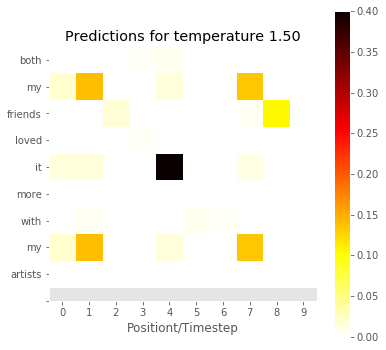

Temperature: 1.75, Sentence: fancy but never quite worse profession enough as fast .


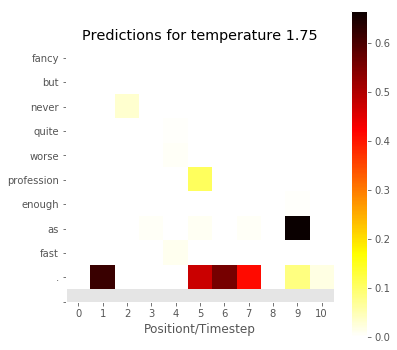

Temperature: 2.00, Sentence: prove whatever which can be . . its three and 4 movies let stickshift medicine bums to either


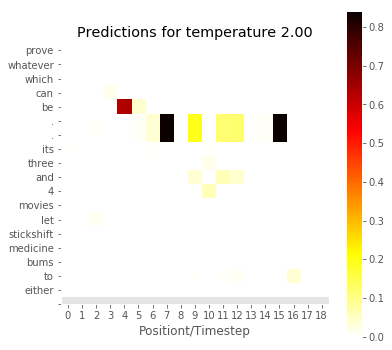

In [475]:
def plot_temp_predictions(temperatures, temp_preds, temp_sentences, sentence_nb = 1):
    
    for temp in temperatures:
        # select sentence for temperature (the first one by default)
        sentence = temp_sentences[temp][sentence_nb-1]
        # select predictions for the corresponding sentence and temp
        preds = temp_preds[temp][sentence_nb-1] #!!! prediction values of the same word might be more than once if the word
                                                # accures several times in a sentence. We did so to observe diagonal prediction!
        
        print("Temperature: %.2f, Sentence: %s"%(temp, sentence))

        
        plt.figure(figsize=(6,6))
        plt.title("Predictions for temperature %.2f"%temp)
           
        plt.imshow(np.transpose(preds), cmap='hot_r')  
        
        plt.xticks(np.arange(0, preds.shape[0]))
        plt.xlabel("Positiont/Timestep")
        
        plt.yticks(np.arange(0, preds.shape[0]), sentence.split())

        plt.colorbar()
        plt.show()
        
        #temp_preds[temp][sentence_nb-1]

plot_temp_predictions(temperatures, temp_preds, temp_sentences)


<b>Code Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]</b>

In [496]:
def generate_continuations(model, sentences, dict_mapping, nb_cont = 10):
    
    for sentence in sentences:
        print("Sentence: %s"%sentence)
        
        for i in range(nb_cont):
            pred_sentece, _ = generate_sentence(model,
                                                dict_mapping,
                                                temperature=1.0,
                                                sentence=sentence)
            print("Continuation %d) %s"%(i+1, pred_sentece))

In [545]:
my_sentence1 = ["our", "teacher", "is"]
my_sentence2 = ["i", "love"]
my_sentence3 = ["our","project", "is"]
my_sentences = [my_sentence1, my_sentence2, my_sentence3]

generate_continuations(models['LSTM'], my_sentences, dict_mapping=dict_mapping)

Sentence: ['our', 'teacher', 'is']
Continuation 1) our teacher is my favorite , i do not have
Continuation 2) our teacher is my favorite vegetable
Continuation 3) our teacher is my dream , now , halloween is my favorite .
Continuation 4) our teacher is drawing scenes and i work as a manager of a lawyer .
Continuation 5) our teacher is to get my bachelors degree , my favorite color i made it even short
Continuation 6) our teacher is painting i love summer so i missed it
Continuation 7) our teacher is the earth for sure what gender are you baking ?
Continuation 8) our teacher is a lot more talent as well . have you read ?
Continuation 9) our teacher is fun , i think i will do land a lot when i was single .
Continuation 10) our teacher is fine , but try burgers they can get it
Sentence: ['i', 'love']
Continuation 1) i love sitting salad there and reading the books
Continuation 2) i love eating raw cheese . r b , green , ha !
Continuation 3) i love singing food , when i have work i love ta

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer**

In [51]:
Input_embedding = Input(shape=(1,), name="input")
embedding_layer = Embedding(nb_tokens,
                            embedding_size,
                            mask_zero=True,
                            weights=embeddings_pre_trained,
                            name="embedding",
                            input_length=None,
                            trainable=False)(Input_embedding)

word_embedding_model = Model(inputs = [Input_embedding], outputs = [embedding_layer])

In [52]:
words_int = np.arange(1, len(dict_mapping))
all_embeddings = word_embedding_model.predict(words_int)

In [56]:
all_embeddings = all_embeddings.reshape((all_embeddings.shape[0], all_embeddings.shape[2]))

In [ ]:
from sklearn.manifold import TSNE
all_embeddings_TSNE = TSNE(n_components=2).fit_transform(all_embeddings)

In [73]:
most_frequent_words = [word[0] for word in sorted_word_dictionary[:500]]

In [75]:
most_frequent_words_index = [dict_mapping.index(word)-1 for word in most_frequent_words]
frequent_word_embeddings_TSNE = all_embeddings_TSNE[most_frequent_words_index]

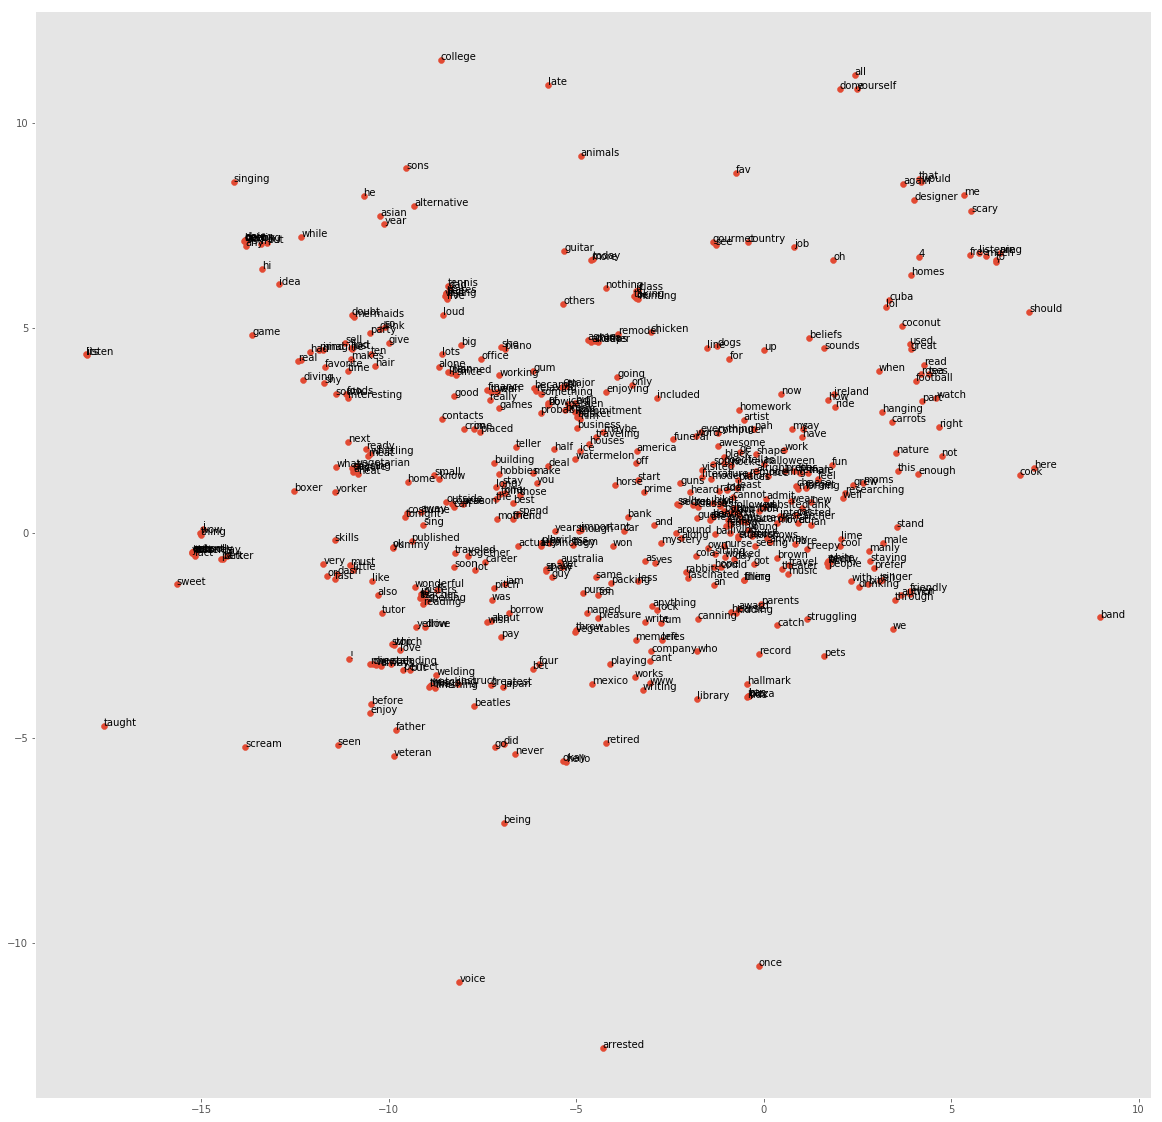

In [76]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(frequent_word_embeddings_TSNE[:, 0], frequent_word_embeddings_TSNE[:, 1])

for i, txt in enumerate(dict_mapping[1:501]):
    ax.annotate(txt, (frequent_word_embeddings_TSNE[i, 0], frequent_word_embeddings_TSNE[i, 1]))

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer**

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




<b>Code For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]</b>

In [397]:
def filter_converstaions(conversations, rare_words):
    """
    Selects question and answer pairs from conversations
    """
    q_a_dataset = [[], []]
    for conversation in conversations:
        
        # idetify number of question and answer in a conversation
        nb_q_a_paris = len(conversation)//2
        
        for i in range(nb_q_a_paris):
            
            q = conversation[2*i]
            a = conversation[2*i + 1]
            
            # drop them if one of them contains a word not in a dictionary
            if contains_rare_word(q.split(), rare_words) or contains_rare_word(a.split(), rare_words):
                continue
            
            q_a_dataset[0].append(q)
            q_a_dataset[1].append(a)
    
    return q_a_dataset[0], q_a_dataset[1]

In [398]:
q_orig , a_orig = filter_converstaions(conversations, rare_words)

<b>Code: You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]
</b>

In [354]:
def standardize_conversations(questions, answers, dict_mapping, max_len=27):
    """
    Standardize the list of questions and answers to be used for training. Performs padding and truncation and converts
    string words to corresponding integers in the list dict_mapping.
    
    Raises an error if number of questions is not equal to number of answers
    :param questions: List of all questions
    :param answers: List of corresponding answers
    :param dict_mapping: Mapping list used for converting words to integers
    :param max_len: Truncate sentences if they exceed max_len, otherwise padd them with zero.
    """
    assert(len(questions) == len(answers))
    
    # lists containg standardize questions and answers
    std_questions = []
    std_answers   = []
    
    # We don't want start and end words in questions
    for q, a in zip(questions, answers):
        question = []
        answer   = []
        
        for word in q.split():
            question.append(dict_mapping.index(word))
        
        answer.append(dict_mapping.index('START'))
        for word in a.split():
            answer.append(dict_mapping.index(word))
        answer.append(dict_mapping.index('END'))
        
        std_questions.append(question)
        std_answers.append(answer)
    
    std_questions = pad_sequences(std_questions, maxlen=max_len, padding='post', truncating='post')
    std_answers   = pad_sequences(std_answers, maxlen=max_len, padding='post', truncating='post')
    
    return std_questions, std_answers

In [399]:
q, a = standardize_conversations(q_orig, a_orig, dict_mapping, max_len=25)

<b> We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated.

Code: Train your chatbot model on your dataset. [1 pt] </b>

In [540]:
# ToDO whyyyyyyyyy??????????????
#context = Input(shape=(maxlen-2,), name="input_context")
context = Input(shape=(max_tokens,), name="input_context")
#shared_embedding = E['GRU']

shared_embedding = Embedding(nb_tokens,
                            embedding_size,
                            mask_zero=True,
                            weights=embeddings_pre_trained,
                            name="embedding",
                            input_length=None,
                            trainable=True)

context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(128, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(max_tokens-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(128, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])

# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(nb_tokens, activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 24)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 25)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             879232      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 128), (None, 131584      embedding[0][0]           

In [542]:
X = np.array(q)
A = np.array(a)

T = A.reshape((A.shape[0], A.shape[1], 1))
chatbox_log = Chatbot.fit({'input_context':X, 'input_answer':A[:, :-1]}, {'output': T[:, 1:, :]}, 
                          epochs=15,
                          validation_split=validation_split,
                          batch_size=batch_size,
                         callbacks=[EarlyStopping()]).history

Train on 40379 samples, validate on 10095 samples
Epoch 1/15
40379/40379 [==============================] - 111s 3ms/step - loss: 4.4559 - acc: 0.2684 - val_loss: 3.8821 - val_acc: 0.3321
Epoch 2/15
40379/40379 [==============================] - 89s 2ms/step - loss: 3.6971 - acc: 0.3456 - val_loss: 3.6600 - val_acc: 0.3523
Epoch 3/15
40379/40379 [==============================] - 82s 2ms/step - loss: 3.4948 - acc: 0.3603 - val_loss: 3.5515 - val_acc: 0.3592
Epoch 4/15
40379/40379 [==============================] - 77s 2ms/step - loss: 3.3676 - acc: 0.3691 - val_loss: 3.4937 - val_acc: 0.3647
Epoch 5/15
40379/40379 [==============================] - 71s 2ms/step - loss: 3.2712 - acc: 0.3765 - val_loss: 3.4551 - val_acc: 0.3691
Epoch 6/15
40379/40379 [==============================] - 72s 2ms/step - loss: 3.1902 - acc: 0.3831 - val_loss: 3.4292 - val_acc: 0.3715
Epoch 7/15
40379/40379 [==============================] - 72s 2ms/step - loss: 3.1195 - acc: 0.3883 - val_loss: 3.4126 - val_ac

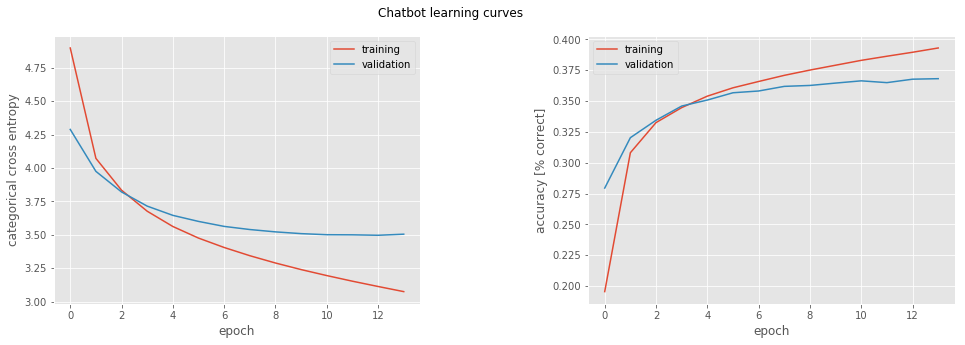

In [531]:
fig_chatbot = plot_history(chatbox_log, "Chatbot learning curves")

<b> Code Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] </b>

<b>Code After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]</b>

<b>Code Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 bonus pts]</b>

In [532]:
def chat_with_bot(model, query, dict_mapping, max_len=25, temperature=1.0):
    input_query = np.array([[dict_mapping.index(word) for word in query]])
    input_query = pad_sequences(input_query, maxlen=max_len, padding='post', truncating='post')
    
    response = [[dict_mapping.index('START')]]
    response = pad_sequences(response, maxlen=max_len-1, padding='post', truncating='post')
    
    response_words = []
    
    for i in range(max_len-2):
        preds = model.predict([input_query, response])
        next_word = sample(preds[0][i], temperature)
        
        if next_word == dict_mapping.index('END'):
            break
        response[0, i+1] = next_word
        response_words.append(dict_mapping[next_word])
    
    return " ".join(response_words)

In [535]:
# Random 10 contex-answer pairs
index = np.random.permutation(len(q_orig))[:10]
print("Temperature: 0.5")
for i in range(10):
    answer_bot = chat_with_bot(Chatbot, q_orig[index[i]].split(), dict_mapping, temperature=0.5)
    true_answer = a_orig[index[i]]
    print("\nQuestion:      {}\nAnswer by bot: {}\nTrue answer:   {}".format(q_orig[index[i]], answer_bot, true_answer))

Temperature: 0.5

Question:      no i am always at the beach
Answer by bot: i am thinking about my nails done .
True answer:   the beach is nice , but i do not get to go too often .

Question:      i definitely would call the police if you think that is the case
Answer by bot: sometimes it is a lot of to do .
True answer:   the police told me to go join my mom

Question:      lol . my brothers have that habit as well .
Answer by bot: i love pizza . i have two cats . . . . . . . . . .
True answer:   in school i did track and field , and won trophies , did you do sports ?

Question:      i love the smell of it though
Answer by bot: i have two dogs . i love to cook , but i have two dogs .
True answer:   nothing better than bacon for breakfast

Question:      you can invest in my new company ! you may get rich from it .
Answer by bot: i am sorry . i am sure . i love the beach .
True answer:   that sounds exciting , i am a teacher so i do not make much !

Question:      nice . i just got my

In [537]:
# Random 10 contex-answer pairs
index = np.random.permutation(len(q_orig))[:10]
print("Temperature: 1.0")

for i in range(10):
    answer_bot = chat_with_bot(Chatbot, q_orig[index[i]].split(), dict_mapping, temperature=1.0)
    true_answer = a_orig[index[i]]
    print("\nQuestion:      {}\nAnswer by bot: {}\nTrue answer:   {}".format(q_orig[index[i]], answer_bot, true_answer))

Temperature: 1.0

Question:      i met you yesterday and you are homeless now
Answer by bot: oh . i wish i had no time yet . but i feel inside my dogs come
True answer:   unfortunately , but someday i will earn enough on amazon to get a place .

Question:      i am listening to so metal , metallica actually . they are my favorite .
Answer by bot: me too , i love fish . i want one older than humus .
True answer:   nice . i am currently grading homework . i teach 1st graders

Question:      i am totally afraid of sharks .
Answer by bot: i agree . i am proud of it .
True answer:   they are actually pretty nice once you get to know them

Question:      i want a big family and some dogs
Answer by bot: i see your stand on my sleep . hoping to find something
True answer:   i thought i wanted 4 kids but i am okay with just having 2 . it is cheaper !

Question:      an amazing buddhist . tell me more !
Answer by bot: i try using videos of summer .
True answer:   i dance for a living on the week

In [553]:
def self_talking(model, init_thought, dict_mapping, temperature=0.75, conversation_len=100):
    answer = init_thought
    
    print("Person 1: {}".format(init_thought))
    for i in range(conversation_len):
        if i%2 == 0:
            person = "Person 2"
        else:
            person = "Person 1"
        answer = chat_with_bot(Chatbot, answer.split(), dict_mapping, temperature=temperature)
        print("{}: {}".format(person, answer))

In [564]:
self_talking(Chatbot, "kill yourself", dict_mapping)

Person 1: kill yourself
Person 2: hey there , i have been everywhere i am of a doctor .
Person 1: i am sorry you know you are a good person
Person 2: i am ok , thanks for it .
Person 1: it is great , it was tough for kids , she has a flexible person .
Person 2: my mom would like to play basketball but i build them .
Person 1: i enjoy to go to baseball and love it
Person 2: whats your favorite food ?
Person 1: i do not like that .
Person 2: i agree . i like to paint ! i am vegetarian because i am allergic to them .
Person 1: ok . i am not kidding . i am good too .
Person 2: nice . you must get around ! i could not eat it
Person 1: i am sorry about that . how old are you ?
Person 2: i am good . how about you ?
Person 1: i am good , my sons are very well .
Person 2: i am going to make some money to pass . i am swimming in the city .
Person 1: good luck to you . i am a teacher
Person 2: i am not close , i want to watch tv shows . but they are awesome
Person 1: good luck . you know you are 